In [1]:
import pandas as pd
 
# Define the heads, relations, and tails
head = ['drugA', 'drugB', 'drugC', 'drugD', 'drugA', 'drugC', 'drugD', 'drugE', 'gene1', 'gene2','gene3', 'gene4', 'gene50', 'gene2', 'gene3', 'gene4']
relation = ['treats', 'treats', 'treats', 'treats', 'inhibits', 'inhibits', 'inhibits', 'inhibits', 'associated', 'associated', 'associated', 'associated', 'associated', 'interacts', 'interacts', 'interacts']
tail = ['fever', 'hepatitis', 'bleeding', 'pain', 'gene1', 'gene2', 'gene4', 'gene20', 'obesity', 'heart_attack', 'hepatitis', 'bleeding', 'cancer', 'gene1', 'gene20', 'gene50']
 
# Create a dataframe
df = pd.DataFrame({'head': head, 'relation': relation, 'tail': tail})
df

,head,relation,tail
0,drugA,treats,fever
1,drugB,treats,hepatitis
2,drugC,treats,bleeding
3,drugD,treats,pain
4,drugA,inhibits,gene1
5,drugC,inhibits,gene2
6,drugD,inhibits,gene4
7,drugE,inhibits,gene20
8,gene1,associated,obesity
9,gene2,associated,heart_attack


In [47]:
import networkx as nx
import matplotlib.pyplot as plt
 
# Create a knowledge graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['head'], row['tail'], label=row['relation'])

In [48]:
# 计算连通分量
connected_components = list(nx.connected_components(G))
print(connected_components)

[{'cancer', 'drugA', 'gene4', 'gene1', 'fever', 'gene2', 'gene50', 'heart_attack', 'pain', 'drugC', 'obesity', 'drugD', 'bleeding'}, {'drugE', 'drugB', 'gene3', 'hepatitis', 'gene20'}]


In [ ]:
# Visualize the knowledge graph
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
# plt.show()

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import re

# 读取待处理数据
def read_data(path):
    df = pd.read_excel(path)
    return df

In [2]:
# 读取数据
path = r"./file/test_data.xlsx"
df = pd.read_excel(path)
df.head()

,bssid,ssid,device
0,06:05:88:50:6e:5e,ChangCheng-Hotel,292441079813746790
1,06:05:88:7f:5f:37,ChangCheng-Hotel,1220358695135740752
2,28:87:ba:cc:0b:95,TP-Link_0B96_5G,f334be764515dbd36762b78806e6f3d3e2f29b82
3,9c:2b:a6:7a:1c:37,D-44,1312412990815612958
4,12:82:3d:84:6c:da,fafafafafa,81140eb1410e40979932927390578df6b53188cd


In [6]:
# 数据处理
duplicate_wifi = df[['bssid', 'ssid']].drop_duplicates(keep='first').reset_index(drop=True)

# 增加WiFi唯一编号
duplicate_wifi['wifi_id'] = duplicate_wifi.index.factorize()[0]
duplicate_wifi['wifi_id'] = duplicate_wifi['wifi_id'].apply(lambda x:"wifi_" + str(x))

# 两表关联
df_merge = pd.merge(df, duplicate_wifi, how='left', on=['bssid', 'ssid'])
df_merge.head()

,bssid,ssid,device,wifi_id
0,06:05:88:50:6e:5e,ChangCheng-Hotel,292441079813746790,wifi_0
1,06:05:88:7f:5f:37,ChangCheng-Hotel,1220358695135740752,wifi_1
2,28:87:ba:cc:0b:95,TP-Link_0B96_5G,f334be764515dbd36762b78806e6f3d3e2f29b82,wifi_2
3,9c:2b:a6:7a:1c:37,D-44,1312412990815612958,wifi_3
4,12:82:3d:84:6c:da,fafafafafa,81140eb1410e40979932927390578df6b53188cd,wifi_4


In [8]:
# 建立网络图谱
G = nx.Graph()
# for _, row in df_merge.iterrows():
#     G.add_edge(row['wifi_id'], row['device'])
# 批量创建  
df_list = df_merge[['wifi_id', 'device']].values.tolist()
G.add_edges_from(df_list)

In [11]:
# 获取wifi列表
wifi_list = list(set(df_merge['wifi_id']))

# 计算连通分量
connected_components = list(nx.connected_components(G))
_wifi_cluster = []
connected_components_select = [list(wifi_device) for wifi_device in connected_components if len(wifi_device)>2]
# print(connected_components_select)
for cluster, components in enumerate(connected_components_select):
    filtered_data = list(filter(lambda x:re.search('wifi_',x), components))
    for wifi_id in filtered_data:
        _wifi_cluster.append([cluster, wifi_id])
wifi_cluster = pd.DataFrame(_wifi_cluster, columns=['cluster', 'wifi_id'])

# 合并
df_result = pd.merge(df_merge, wifi_cluster, how='inner', on=['wifi_id'])

# 仅一个设备的分组剔除
device_series = df_result.groupby('cluster').device.nunique()
cluster_except = list(device_series[device_series.values==1].index)
df_result = df_result[~df_result['cluster'].isin(cluster_except)]
# 输出
df_result.to_excel(r'./file/result2.xlsx')
df_result.head()

,bssid,ssid,device,wifi_id,cluster
0,06:05:88:50:6e:5e,ChangCheng-Hotel,292441079813746790,wifi_0,0
1,06:05:88:50:6e:5e,ChangCheng-Hotel,533235413714292132,wifi_0,0
2,06:05:88:50:6e:5e,ChangCheng-Hotel,6013c55b9512bbdc7a7450cfe4ee09b5adb764ef,wifi_0,0
3,06:05:88:50:6e:5e,ChangCheng-Hotel,28390ec3ebb156a18dc29d5a8316601059b03894,wifi_0,0
4,06:05:88:50:6e:5e,ChangCheng-Hotel,28b88491b93e182165964eeb39fb0722a858a738,wifi_0,0


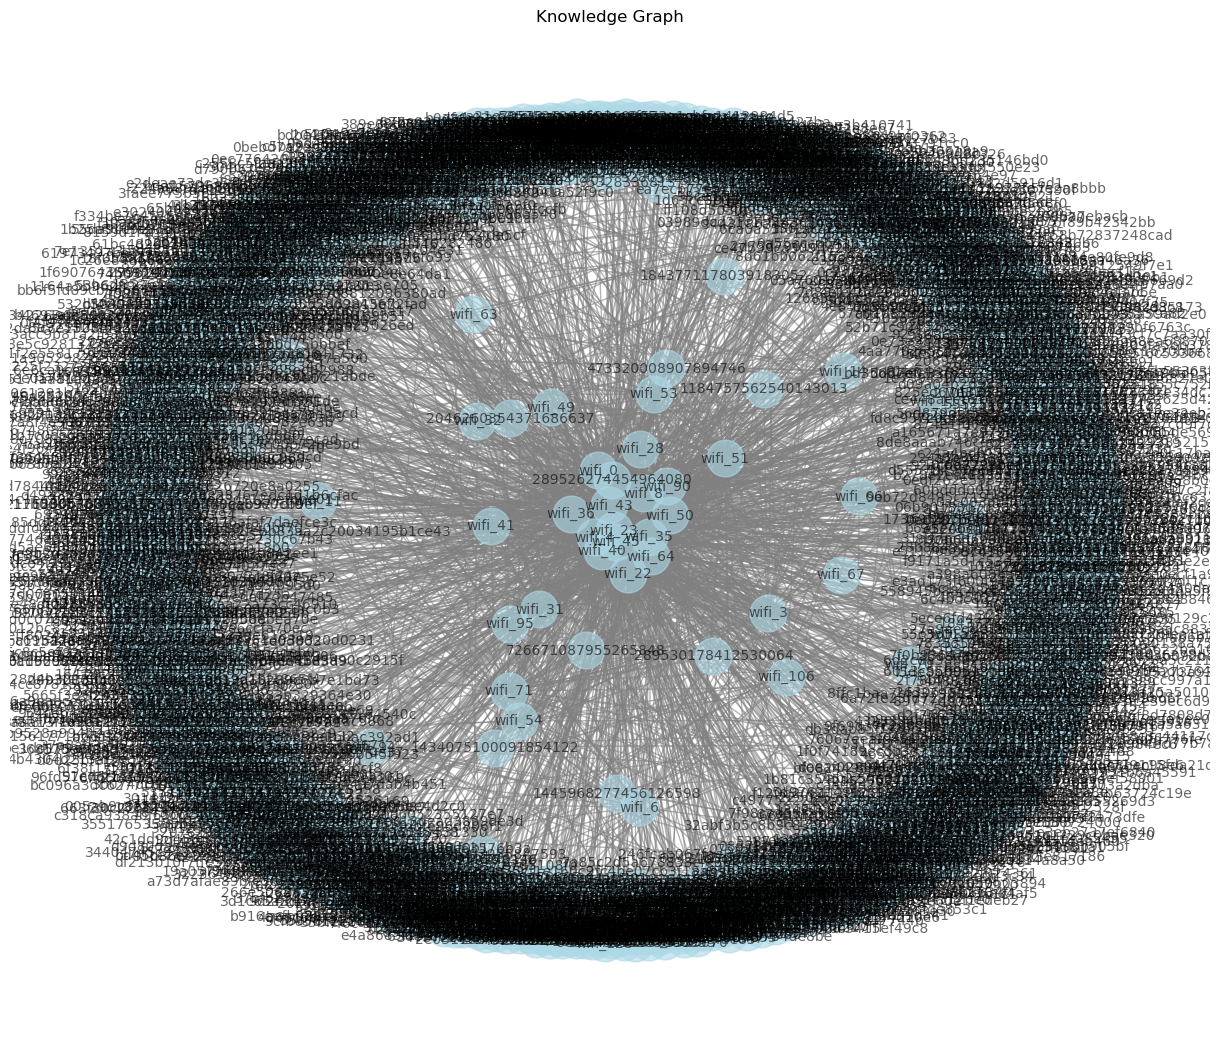

In [12]:
# Visualize the knowledge graph
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

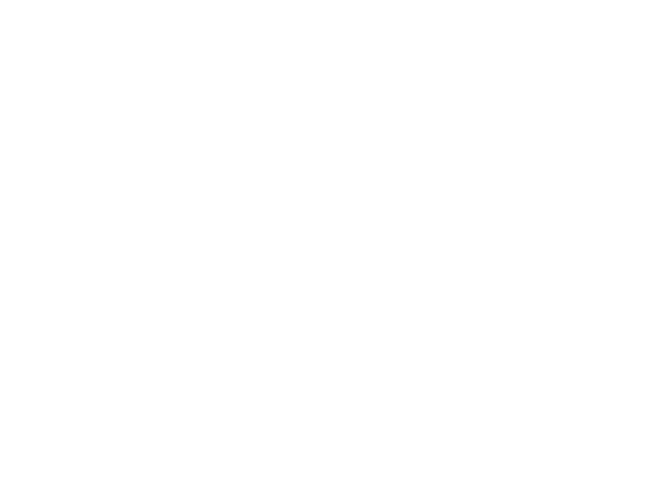

In [128]:
import networkx as nx
 
# 创建一个无向图
G = nx.Graph()
 
# 添加边，模拟网络图
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(4, 5)
G.add_edge(5, 6)
 
# 遍历连通分量并单独输出每个簇
for i, component in enumerate(connected_components):
    G_component = G.subgraph(component).copy()
    nx.draw(G_component, with_labels=True, node_color='skyblue', node_size=800,
            edge_color='black', width=2)
    # 输出到图片文件
#     nx.drawing.nx_pylab.write_png(G_component, f"banyuan_{i}.png")

for i